In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import barbershop
from tqdm import tqdm

In [2]:
sfile = 'file2.txt'
df = pd.read_csv(sfile, sep='\s+')
df.head(5)
print(df.columns)
df['dist'] = 10.0**(df['m-M0'] / 5.0 + 1.0)
df['par'] = 1000.0/df.dist #parallax in mas
df['BV'] = df.B - df.V

Index([u'#Gc', u'logAge', u'[M/H]', u'm_ini', u'logL', u'logTe', u'logg',
       u'm-M0', u'Av', u'm2/m1', u'mbol', u'U', u'B', u'V', u'R', u'I', u'J',
       u'H', u'K', u'Mact'],
      dtype='object')


//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Make some cuts
df = df.loc[np.abs(df.BV - 0.9) < 0.6]
df = df.loc[df.K > 8.0]
df = df.loc[df.logg < 3.5]

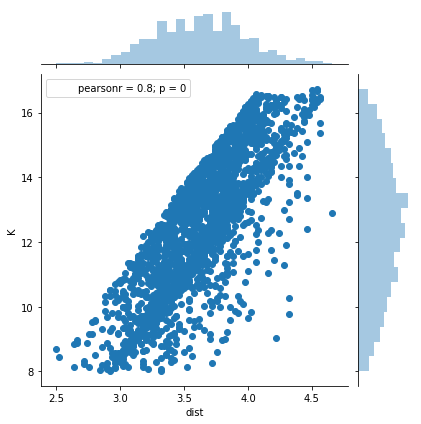

In [4]:
sns.jointplot(np.log10(df.dist), df.K)

In [5]:
#Calculate absolute magnitude (no extinction)
df['MK'] = df.K - 5.0 * np.log10(df.dist) + 5.0

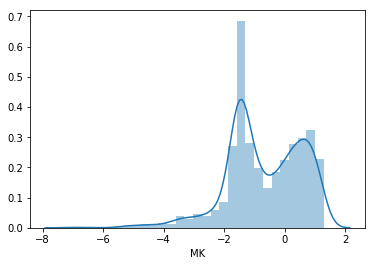

In [6]:
#Plot absolute magnitude in K
sns.distplot(df.MK)

In [7]:
# #Cut anything not directly around the clump
# df = df.loc[np.abs(df.MK + 1.55) < 0.1]
# sns.distplot(df.MK)

In [8]:
#Write the pystan model
import pystan
code = '''
functions {
    real logposexp(real x, real hi, real lo, real lambd) {
        real A;
        A = log(lambd*(exp(lambd*hi)-exp(lambd*lo))^-1);
        return lambd*x + A;
        }
}

data {
    int<lower = 0> N;
    real M_obs[N];
    real M_unc[N];
}

parameters {
    real M_std[N];
    real mu;
    real<lower = 0> sigma;
    real<lower = 0, upper = 1> fout;
    real<lower = 0> lambd;
}

transformed parameters{
    real M_true[N];
    for (i in 1:N)
        M_true[i] = M_std[i] * sigma + mu;
}

model{
    M_std ~ normal(0, 1);
    M_obs ~ normal(M_true, M_unc);
    mu ~ normal(-1.64, 0.1);
    sigma ~ normal(0.04, 0.0001);
    lambd ~ normal(0.46, 0.01);
    fout ~ normal(0.34, 0.01);
    
    for (n in 1:N)
       target += log_mix(fout,
                     normal_lpdf(M_true[n] | mu, sigma),
                     logposexp(M_true[n], max(M_true), min(M_true), lambd));

}

generated quantities{
    vector[N] post_prob;
    real ll_fg;
    real ll_bg;
    
    for (n in 1:N){
        ll_fg = log(fout) + normal_lpdf(M_true[n] | mu, sigma);
        ll_bg = log(1-fout) + logposexp(M_true[n], max(M_true), min(M_true), lambd);
        post_prob[n] = exp(ll_fg - log_sum_exp(ll_fg, ll_bg));
    }
}
'''
sm = pystan.StanModel(model_code=code, model_name='ClumpModel')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL ClumpModel_d0bc6fea70bc988b47c783b11ba95d40 NOW.


In [9]:
err = np.ones(len(df)) * 0.01
MK = df.MK + np.random.randn(len(df))*err
dat = {'N': len(MK),
      'M_obs': MK,
      'M_unc': err}
fit = sm.sampling(data=dat, iter=50, chains=1)

//anaconda/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


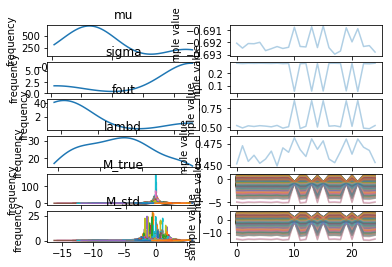

In [15]:
fit.plot(pars=['mu','sigma','fout','lambd','M_true','M_std'])
plt.show()

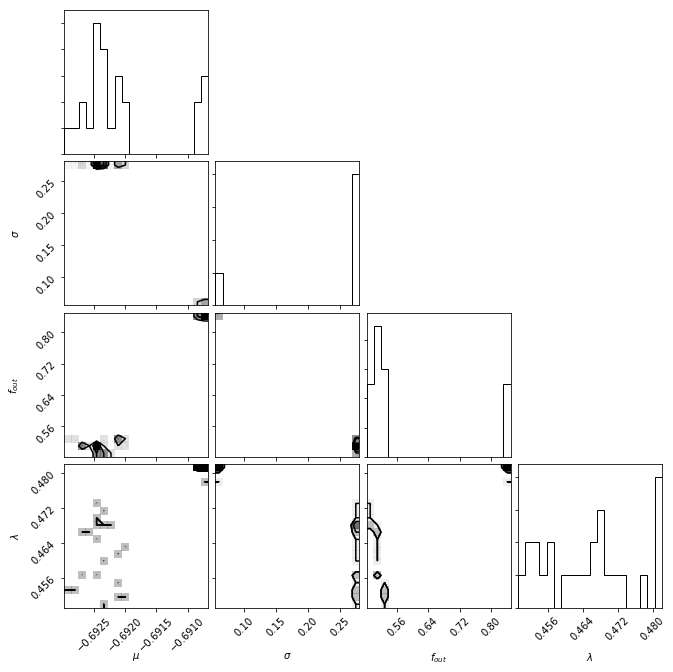

In [11]:
trace=fit.extract()
import corner
chain = np.array([trace['mu'],trace['sigma'],trace['fout'],trace['lambd']])
corner.corner(chain.T,\
            labels=[r'$\mu$',r'$\sigma$',r'$f_{out}$',r'$\lambda$'])
plt.show()

In [12]:
#Sum and normalize the posterior probabilities
pp = trace['post_prob']
post_prob = np.sum(pp,axis=0)/pp.shape[0]

In [13]:
mu = np.median(trace['mu'])
sigma = np.median(trace['sigma'])
fout = np.median(trace['fout'])
lambd = np.median(trace['lambd'])
# sout = np.median(trace['sout'])
mtrue = np.median(trace['M_true'],axis=0)
fg = (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(mtrue-mu)**2/(2*sigma**2))
bg = (lambd*(np.exp(lambd*mtrue.max()) - np.exp(lambd*mtrue.min()))**-1)\
                                               *np.exp(lambd*mtrue)
pp = fout*fg + (1-fout)*bg

Text(0,0.5,u'Units arbitrary')

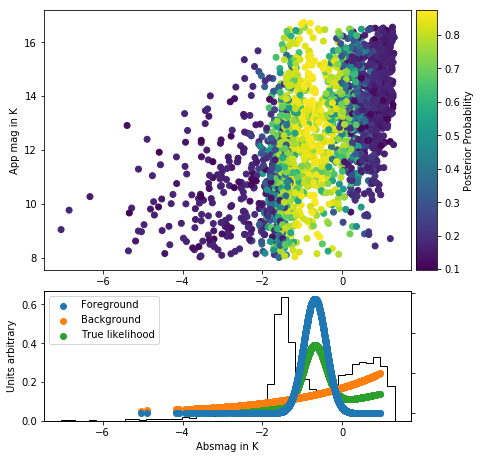

In [14]:
left, bottom, width, height = 0.1, 0.45, 0.85, 0.60
fig = plt.figure(1, figsize=(6,6))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3])
cax = fig.add_axes([left+width+0.01, bottom, 0.05, height])
xax2 = xax.twinx()
xax2.set_yticklabels([])

c = sax.scatter(MK,df.K,c=post_prob)
fig.colorbar(c, cax=cax, label='Posterior Probability')
xax.hist(MK, histtype='step', bins='sqrt',color='k',normed=True,zorder=1000)

xax2.scatter(mtrue,fg,label='Foreground', zorder=999)
xax2.scatter(mtrue,bg,label='Background', zorder=998)
xax2.scatter(mtrue, pp,label='True likelihood', zorder=997)
xax2.legend()

xax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')